# Peripheral Analyzer
This notebook compares the different audio encoders in relation to the cochlea. As such, these algorithms will only convert the audio to spectral representations and avoid the echoic memory issue for now. We will compare how these raw representations differ in terms of time taken to complete on a per file basis as well as information gain using them.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import soundfile as sf
import librosa as libr
import librosa.display as ldis

# Reading Database
Using pandas to read in the database for audio loading

In [2]:
dataset = pd.read_csv('../ESC-50/meta/esc50.csv')
dataset.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [3]:
samples = dataset.sample(2)
samples.head()

,filename,fold,target,category,esc10,src_file,take
1377,4-173865-B-9.wav,4,9,crow,False,173865,B
1632,5-160614-B-48.wav,5,48,fireworks,False,160614,B


## Reading in Audio

In [4]:
y0, sr0 = libr.core.load('../ESC-50/audio/' + samples.iloc[0]['filename'], sr=16000, mono=True)
y1, sr1 = libr.core.load('../ESC-50/audio/' + samples.iloc[1]['filename'], sr=16000, mono=True)

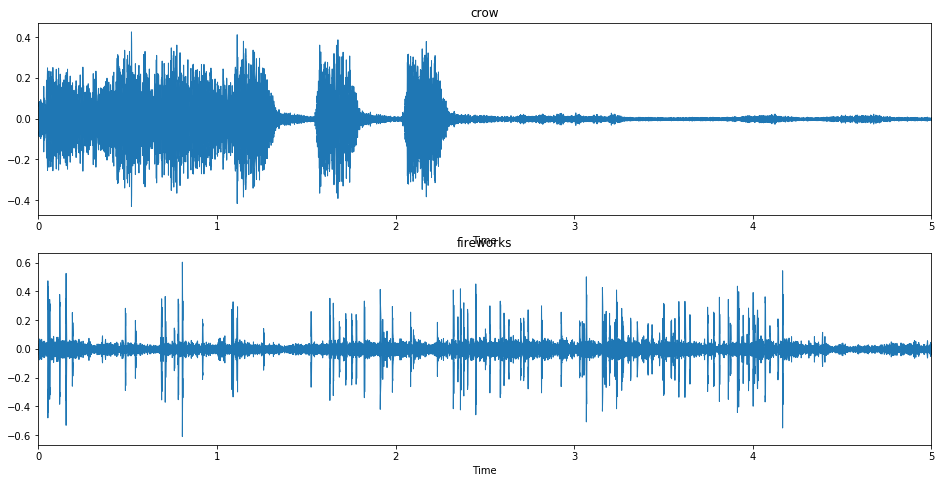

In [5]:
plt.figure(figsize=(16, 12))
plt.title('Waveform')
ax=plt.subplot(3,1,1)
ax.set_title(samples.iloc[0]['category'])
ldis.waveplot(y0, sr0)
ax=plt.subplot(3,1,2)
ax.set_title(samples.iloc[1]['category'])
ldis.waveplot(y1, sr1)

## Halfwave Rectification

In [6]:
y0 = y0.clip(min=0)
y1 = y1.clip(min=0)

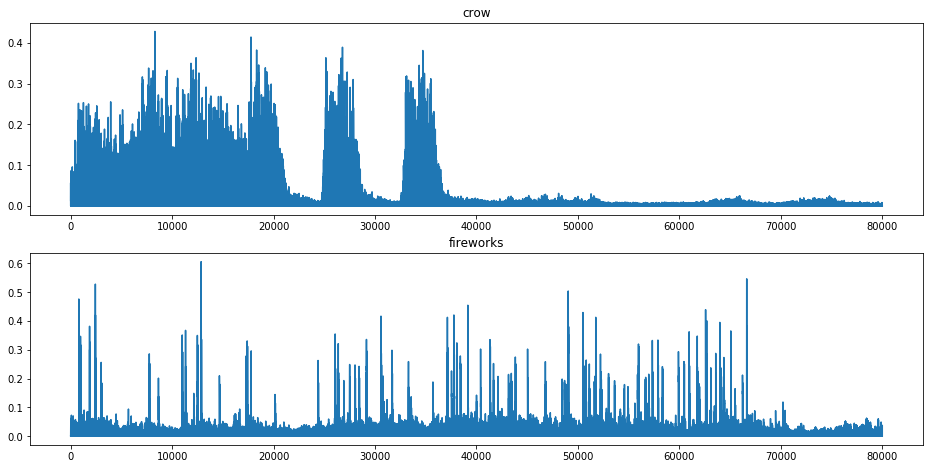

In [7]:
plt.figure(figsize=(16, 12))
plt.title('Half Rectified')
ax=plt.subplot(3,1,1)
ax.set_title(samples.iloc[0]['category'])
plt.plot(y0)
ax=plt.subplot(3,1,2)
ax.set_title(samples.iloc[1]['category'])
plt.plot(y1)

In [8]:
y0 = y0[np.newaxis, :]
y1 = y1[np.newaxis, :]

## Filterbanks
A number of filterbanks are used throughout audio analytics and here we will compare them.

In [9]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
from kapre.utils import Normalization2D

Using TensorFlow backend.


In [10]:
def mel_spec_model(input_shape, n_mels, power_melgram, decibel_gram, sr):
    model = Sequential()
    model.add(Melspectrogram(
        sr=sr,
        n_mels=n_mels,
        power_melgram=power_melgram,
        return_decibel_melgram = decibel_gram,
        input_shape=input_shape,
        trainable_fb=False
    ))
    model.add(Normalization2D(str_axis='freq'))
    return model

def spec_model(input_shape, decibel_gram):
    model = Sequential()
    model.add(Spectrogram(
        return_decibel_spectrogram = decibel_gram,
        input_shape=input_shape
    ))
    model.add(Normalization2D(str_axis='freq'))
    return model

def check_model(model, debug=False):
    if debug:
        model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, sr, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    ldis.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=sr)

def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#         result = np.swapaxes(result, 1, 2)
#         print(result.shape)
    return result

### Unfiltered Spectrum

Epoch 1/1
2/2 [==============================] - 0s 64ms/step - loss: 1.3333
(1, 80000)
(1, 80000)


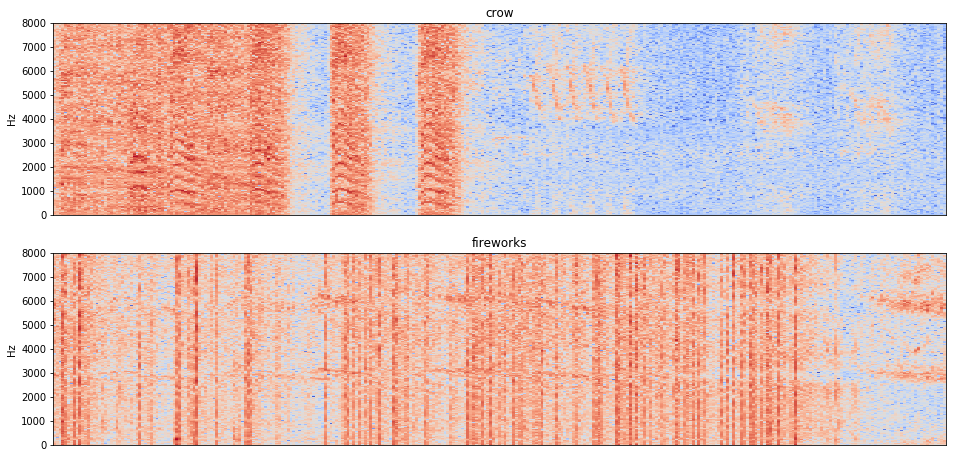

In [11]:
plt.figure(figsize=(16, 12))
spec_model = spec_model(y0.shape, True)
check_model(spec_model)
ax=plt.subplot(3,1,1)
ax.set_title(samples.iloc[0]['category'])
visualise_model(spec_model, sr=sr0, src=y0)
ax=plt.subplot(3,1,2)
ax.set_title(samples.iloc[1]['category'])
visualise_model(spec_model, sr=sr1, src=y1)

### Mel Filter
The popular mel filterbank

Epoch 1/1
2/2 [==============================] - 0s 58ms/step - loss: 1.3341
(1, 80000)
(1, 80000)


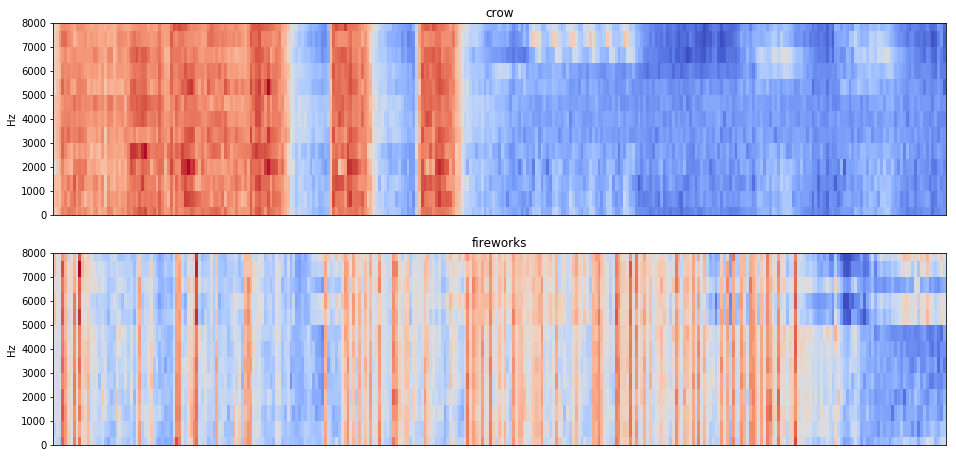

In [12]:
plt.figure(figsize=(16, 12))
n_mels = 13
mel_model = mel_spec_model(y0.shape, n_mels, True, True, sr0)
check_model(mel_model)
ax=plt.subplot(3,1,1)
ax.set_title(samples.iloc[0]['category'])
visualise_model(mel_model, y0, sr=sr0)
ax=plt.subplot(3,1,2)
ax.set_title(samples.iloc[1]['category'])
visualise_model(mel_model, y1, sr=sr1)

### Gammatone 
For more humanlike hearing

In [13]:
from gammatone import gtgram, fftweight

In [14]:
def gtgram_plot(
        gtgram_function,
        x, fs, window_time, 
        hop_time, channels, f_min
        ):
    """
    Plots a spectrogram-like time frequency magnitude array based on gammatone
    subband filters.
    :param gtgram_function: A function with signature::
        fft_gtgram(
            wave,
            fs,
            window_time, hop_time,
            channels,
            f_min)
    See :func:`gammatone.gtgram.gtgram` for details of the paramters.
    """
    gtg = gtgram_function(x, fs, window_time, hop_time, channels, f_min)
    result = np.flipud(20 * np.log10(gtg))

    ldis.specshow(result, y_axis='linear', fmin=f_min, fmax=8000, sr=fs)

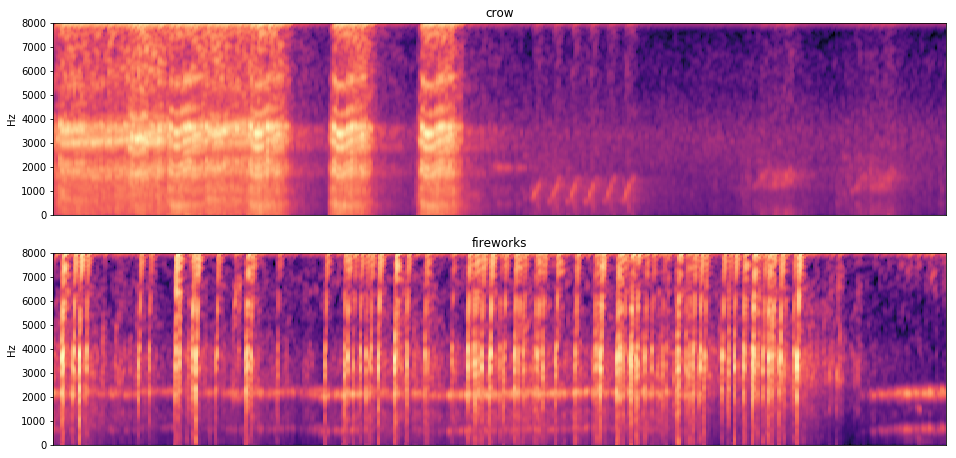

In [15]:
plt.figure(figsize=(16, 12))
ax=plt.subplot(3,1,1)
ax.set_title(samples.iloc[0]['category'])
gtgram_plot(gtgram.gtgram, y0[0][:], sr0, 0.02, 0.01, 2048, 20)
ax=plt.subplot(3,1,2)
ax.set_title(samples.iloc[1]['category'])
gtgram_plot(gtgram.gtgram, y1[0][:], sr1, 0.02, 0.01, 2048, 20)